In [1]:
import sys
sys.path.append("/u/lukas.rilling/dev/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
%matplotlib widget

from returnn_training_progress import get_epoch_data
from returnn_training_plot_nb import plot_df
%load_ext autoreload
%autoreload 2

In [2]:
globs = [
    # "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/200ep/*/no_specaug/ce_ls_0.1/training",
    # "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/no_specaug/ce_ls_0.1/training",
    "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector*/200ep/*/ce_ls_*/training",
    "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_cnn_x_vector*/*/ce_ls_*/training",
    # "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_cnn_x_vector/*/no_specaug/*/ce_ls_0.1/training",
]
lr_files = []
for g in globs:
    lr_files += glob.glob(g)

common_prefix = os.path.commonpath(lr_files)
common_sufix = os.path.commonpath([l[::-1] for l in lr_files])[::-1]

names = []
for f in lr_files:
    names.append(f.removeprefix(common_prefix).removesuffix(common_sufix))

files = dict(zip(lr_files, names))
files

{'/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_0.1/training': '/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_0.1/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_1.0/training': '/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_1.0/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/tts_pretrained/ce_ls_0.1/training': '/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/tts_pretrained/ce_ls_0.1/',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_

In [3]:
partition_epochs = {
    "/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/*/ce_ls_*/training": 3
}

partition_epochs_2 = {}
for k,v in partition_epochs.items():
    new = {key: v for key in glob.glob(k)}
    partition_epochs_2 = {**partition_epochs_2, **new}

partition_epochs = partition_epochs_2
partition_epochs

{'/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/specaug/ce_ls_0.1/training': 3,
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/specaug/ce_ls_1/training': 3,
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/no_specaug/ce_ls_0.1/training': 3,
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/glowTTS_ASR_ffn_x_vector/no_specaug/ce_ls_1/training': 3}

/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_0.1/training: 1
/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/basic_init/ce_ls_1.0/training: 1
/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/tts_pretrained/ce_ls_0.1/training: 1
/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/raw_audio/joint_models/flow_given_alignment/ga_glowTTS_ASR_ffn_x_vector_v2/200ep/tts_pretrained/ce_ls_1.0/training: 1
/u/lukas.rilling/experiments/glow_tts_asr_v2/alias/experiments/librispeech/joint_training/given_alignments/r

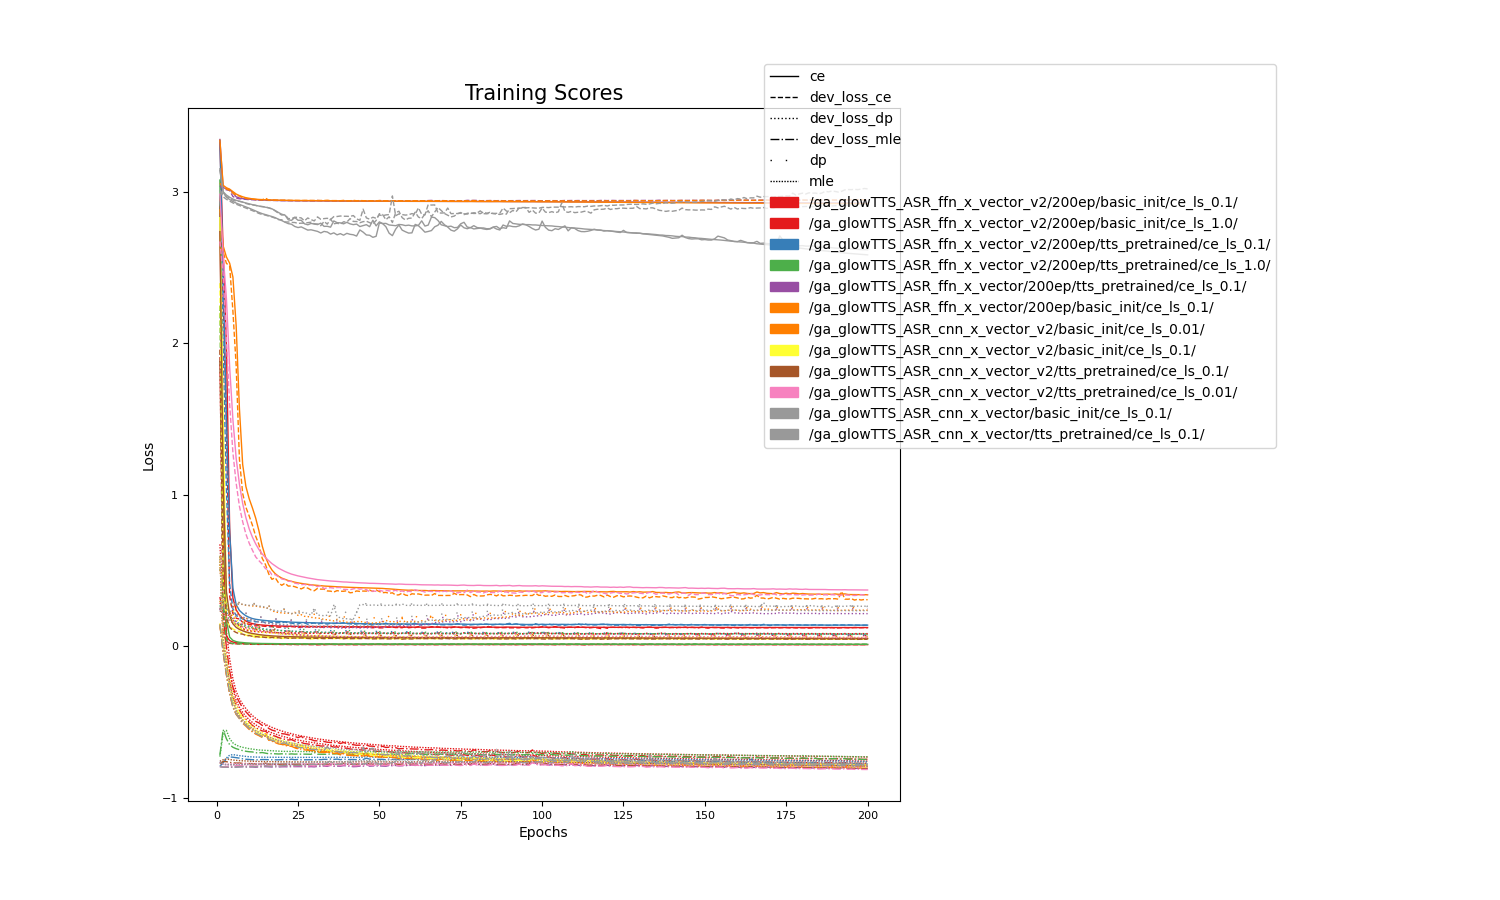

In [4]:
error_data = {}
labels = list(files.values())
for i, lr_file in enumerate(lr_files):
    breakpoint()
    data = get_epoch_data(lr_file, epoch=None)
    if data is None:
        continue
    p_e = 1 if lr_file not in partition_epochs else partition_epochs[lr_file]
    print(f"{lr_file}: {p_e}")
    error_data_tmp = []
    for ep, ep_data in data.items():
        ep_data_error = ep_data.pop("error", {})
        error_data_tmp.append(ep_data)
        error_data_tmp[int(ep%p_e)-1].update(ep_data_error)
        if ep % p_e == 0:
            ep_data2 = pd.DataFrame(error_data_tmp).mean().to_dict()
            error_data[(labels[i], int(ep//p_e))] = ep_data2
            # error_data[(labels[i], int(ep//p_e))].update(ep_data_error)
            error_data_tmp = []
df = pd.DataFrame.from_dict(error_data, orient="index")
plot_df(
    df,
    plot_lr=False,
    large_font=False,
    shrink_axes=0.6,
    # ylim_max=4,
    # ylim_min=-0.9,
    keys_exclude="devtrain",
    color_map="Set1",
    draggable=True
)

In [5]:
# error_data = {}
# labels = list(files.values())
# for i, lr_file in enumerate(lr_files):
#     data = get_epoch_data(lr_file, epoch=None)
#     if data is None:
#         continue
#     for ep, ep_data in data.items():
#         ep_data_error = ep_data.pop("error", {})
#         error_data[(labels[i], int(ep))] = ep_data
#         error_data[(labels[i], int(ep))].update(ep_data_error)
# df = pd.DataFrame.from_dict(error_data, orient="index")
# plot_df(
#     df,
#     plot_lr=False,
#     large_font=False,
#     shrink_axes=0.6,
#     # ylim_max=4,
#     ylim_min=-0.9,
#     keys_exclude="devtrain|ctc",
#     color_map="Set1",
# )